In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import constrainedzoom as cz
import numpy as np
import matplotlib.pyplot as plt
import constrainedzoom.plots as czp

In [2]:
HIGH = 32
LOW = 32
SCALE = 2
OFFSET = 5
test = cz.methods.filtered.FilteredZoomConstrained(nP=HIGH, nW=LOW, hires_window_scale=SCALE, offset=OFFSET)

# Filtering Example

First, I create the initial conditions. get_whitenoise() is a method that returns Gaussian whitenoise using a normal distribution with $\mu=0$ and $\sigma=1$. The noise is returned in Fourier space (k-space, or wavenumber space), so it's transformed back into position space (x-space). 

Text(0, 0.5, 'Overdensity')

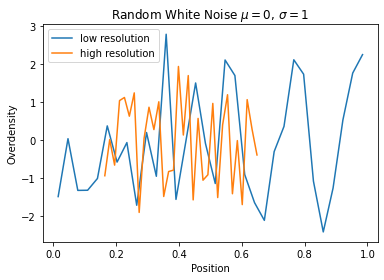

In [3]:
lo_noise, hi_noise = test._get_whitenoise()
lo_pos, hi_pos = test.xs() #returns positions of delta(x)
plt.plot(lo_pos, lo_noise.in_real_space(), label="low resolution")
plt.plot(hi_pos, hi_noise.in_real_space(), label="high resolution")
plt.title("Random White Noise $\mu=0$, $\sigma=1$")
plt.legend()
plt.xlabel("Position")
plt.ylabel("Overdensity")

There are several issues with this, if we were to use it as the initial conditions for our N-body code. An actual overdensity distribution will not necessarily have $\sigma =1$ although by definition $\mu \approx 0$. And, if we were to evolve the simulation, it would look different than an actual matter distribution. The next step is to apply a "matter transfer function", and this will make the noise look like an actual matter distribution.

Text(0.5, 1.0, 'Post-Matter Transfer Function White Noise')

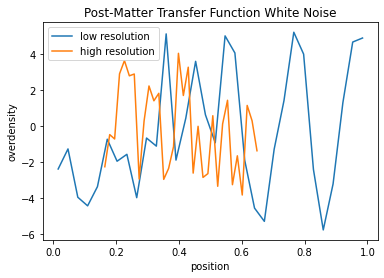

In [4]:
lo_del, hi_del = test._apply_transfer_function(lo_noise, hi_noise)
rsdello = lo_del.in_real_space()
rsdelhi = hi_del.in_real_space()
plt.plot(lo_pos, rsdello, label='low resolution')
plt.plot(hi_pos, rsdelhi, label='high resolution')
plt.legend()
plt.xlabel("position")
plt.ylabel("overdensity")
plt.title("Post-Matter Transfer Function White Noise")

Next we compare the distributions pre and post matter transfer function application.

Text(0.5, 1.0, 'Before and After Transfer Function')

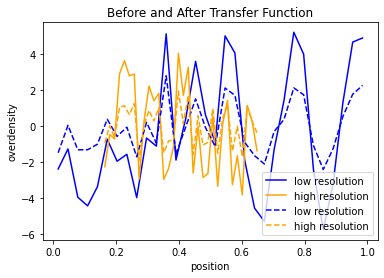

In [5]:
plt.plot(lo_pos, rsdello, 'blue',label='low resolution')
plt.plot(hi_pos, rsdelhi, 'orange',label='high resolution')
plt.plot(lo_pos, lo_noise.in_real_space(), '--',color='blue',label="low resolution")
plt.plot(hi_pos, hi_noise.in_real_space(), '--', color= 'orange',label="high resolution")
plt.legend()
plt.xlabel("position")
plt.ylabel("overdensity")
plt.title("Before and After Transfer Function")

In this case, the matter transfer function was relatively simple. It mostly just increased the magnitude of the overdensities. However by using this method instead of generating a sample with a larger standard deviation, we can implement different transfer functions on the same sample of white noise. The matter transfer function is designed to map the noise to a desired matter power spectrum, and can be as detailed or as complicated as needed.

However, there is a boundary condition that is broken in the above plots. The matter distribution must be continuous along the boundaries and this is not the case. In previous zoom simulations, you would start by generating high-resolution noise for the full volume and down-sample. However, this is memory inefficient. Using the current machine's full capacity to generate a high-resolution volume just to eliminate some points defeats the purpose of zoom simulations.

We can resolve the boundary condition issue by filtering in k-space.

In [6]:
# fourier space pre-filtering

k_nyq_1 = test.nP/2  # N pi / L, but L=1
k_nyq_2 = test.nW * test.window_size_ratio/2
klo = np.linspace(0,k_nyq_1-1,test.nP)
khi = np.linspace(0,k_nyq_2-1,test.nW)
lowy = np.zeros((len(lo_pos),len(klo)))
hiy = np.zeros((len(hi_pos),len(khi)))
print(hiy.shape)
print(lowy.shape)
for i in range(len(khi)):
    hiy[:,i] = np.cos(khi[i]*hi_pos[:])+khi[i]
for i in range(len(klo)):
    lowy[:,i] = np.cos(klo[i]*lo_pos[:])+klo[i]

(32, 32)
(32, 32)


Text(0.5, 1.0, 'Fourier Decomposition of Pre-filtered Field')

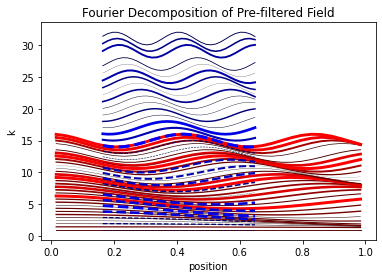

In [7]:
coltest = lo_del-np.min(lo_del)
norm = np.max(coltest)
for i in range(len(klo)):
    col = [coltest[i]/norm,0,0]
    lwidth = coltest[i]/norm *3
    plt.plot(lo_pos, lowy[:,i], color=col, linewidth=lwidth)
coltest = hi_del-np.min(hi_del)
norm = np.max(coltest)
for i in range(len(khi)):
    col = [0,0,coltest[i]/norm]
    lwidth = coltest[i]/norm *3
    if khi[i]>np.max(klo):
        plt.plot(hi_pos, hiy[:,i], color=col, linewidth=lwidth)
    else:
        plt.plot(hi_pos, hiy[:,i], color=col, linewidth=lwidth, linestyle='--')
plt.xlabel("position")
plt.ylabel("k")
plt.title("Fourier Decomposition of Pre-filtered Field")

Text(0.5, 1.0, 'Filtered Fields')

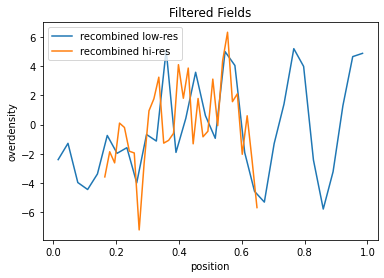

In [8]:
# Real space post-filtering
lo_filt, hi_filt = test._recombine_fields(lo_del, hi_del)
rslofilt, rshifilt = lo_filt.in_real_space(), hi_filt.in_real_space()
plt.plot(lo_pos, rslofilt, label='recombined low-res')
plt.plot(hi_pos, rshifilt, label='recombined hi-res')
plt.legend()
plt.xlabel("position")
plt.ylabel("overdensity")
plt.title("Filtered Fields")

Text(0.5, 1.0, 'High Resolution Region Pre/Post Filtering')

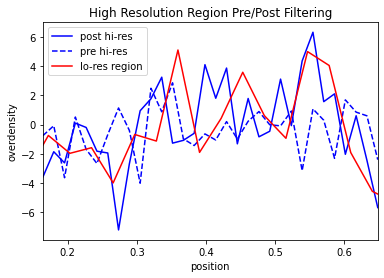

In [9]:
plt.plot(hi_pos, rshifilt, 'b',label='post hi-res')
plt.plot(hi_pos, rsdelhi, 'b--', label='pre hi-res')
plt.plot(lo_pos, rsdello, 'r', label='lo-res region')
plt.legend()
plt.xlabel("position")
plt.xlim(hi_pos[0], hi_pos[-1])
plt.ylabel("overdensity")
plt.title("High Resolution Region Pre/Post Filtering")

# Modification Example

I think the modification process is easiest to understand if we operate on a completely blank field.

Text(0, 0.5, 'Overdensity')

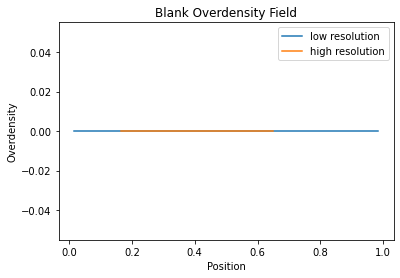

In [10]:
# pre-modification field
lo_noise, hi_noise = test.realization(no_random=True)
lo_pos, hi_pos = test.xs() #returns positions of delta(x)
plt.plot(lo_pos, lo_noise.in_real_space(), label="low resolution")
plt.plot(hi_pos, hi_noise.in_real_space(), label="high resolution")
plt.title("Blank Overdensity Field")
plt.legend()
plt.xlabel("Position")
plt.ylabel("Overdensity")

Now, let's take an example. Let's say that we want to place a galaxy at the center of the high-resolution region. At the center, it will have twice the average density of the simulated "universe" (i.e. it will have an overdensity of 1). Below is the result of that modification.

Text(0, 0.5, 'Overdensity')

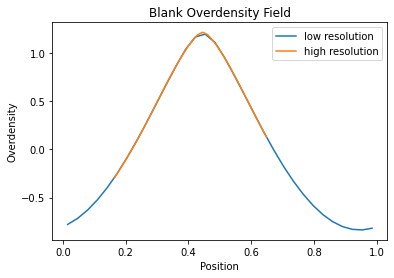

In [21]:
# Adding a constraint vector (for modification)
formod = cz.methods.filtered.FilteredZoomConstrained(nP=HIGH, nW=LOW, hires_window_scale=SCALE, offset=OFFSET)
mod = np.zeros(len(hi_pos))

formod.add_constraint(val=1,potential=True)
lo, hi = formod.realization(no_random=True)
plt.plot(lo_pos, lo, label="low resolution")
plt.plot(hi_pos, hi, label="high resolution")
plt.title("Blank Overdensity Field")
plt.legend()
plt.xlabel("Position")
plt.ylabel("Overdensity")

When we "add" this galaxy, it's more so a shift of the available matter into an overdense region. Thus, we would expect that around this overdense region, we would have underdense regions that we shift the matter _from_. genetIC allows one to propagate these changes across the boundaries of a zoom simulation in a manner consistent with the continuity boundary conditions.

FFTArray([-0.06096671, -0.05978275, -0.05652571, -0.04901764, -0.04217733,
          -0.03377124, -0.02101949, -0.0131791 ,  0.01311406,  0.04864842,
           0.06249831,  0.10582091,  0.28738234,  0.54464717,  0.61911552,
           0.42176362,  0.17640087,  0.07198748,  0.0571161 ,  0.03109713,
          -0.004228  , -0.02476843, -0.03851966, -0.04173124, -0.04640819,
          -0.05413496, -0.05921812, -0.06080203, -0.06186555, -0.06337818,
          -0.06378872, -0.06250706])